In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import warnings
import tes_analysis_tools as tat
import sklearn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
# from tsfresh.feature_extraction import extract_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.utilities.distribution import MultiprocessingDistributor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
sns.set()
warnings.filterwarnings('ignore')

In [2]:
dir = "../WF/exp1/"
savedir = "./exp1_result/"
pulse = np.load(dir + "pulse.npy")
noise = np.load(dir + "noise.npy")
time  = np.load(dir + "time.npy")

n  = pulse.shape[0]
dp = pulse.shape[1]
m  = noise.shape[0]
dt = time[1] - time[0]

# baseline 補正, 先頭からdpbl点の平均をoffsetとして引き去る
dpbl = 200
pulse = tat.correct_baseline(pulse, dpbl)

# 正負反転
pulse = -1.0 * pulse

In [29]:
def regression(data):
    fit = np.polyfit(time, data, 20)
    fit_fn = np.poly1d(fit)
    return fit_fn(time)

# クラスタリング

In [48]:
# df: raw pulse data
df = pd.DataFrame(pulse)
df.index.name = "id"
df_corrected = df.apply(regression, axis=1, result_type="expand")
# 主成分分析
pca_model = PCA(n_components=2)
X_pca = pca_model.fit_transform(df_corrected.values)
pca_df = pd.DataFrame(data=X_pca, index=df_corrected.index, columns=["first_component", "second_component"])

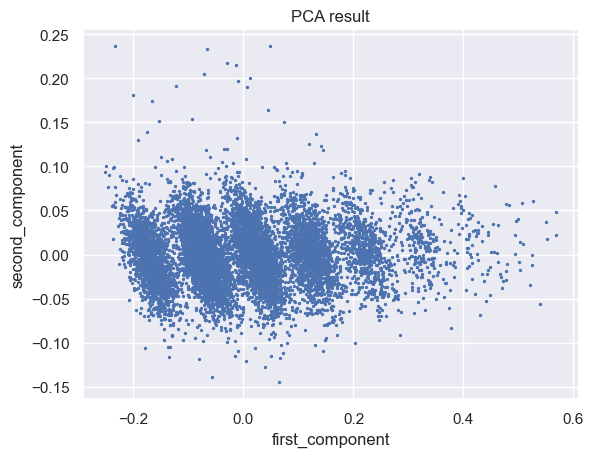

In [49]:
pca_df.plot.scatter(x="first_component", y="second_component", s=2)
plt.title("PCA result")
plt.show()

In [50]:
# K-Means
kmeans_model = KMeans(n_clusters=6)
y_pred_kmeans = kmeans_model.fit_predict(pca_df.values)

# DBSCAN
dbscan_model = DBSCAN(eps=0.015, min_samples=100)
y_pred_dbscan = dbscan_model.fit_predict(pca_df.values)

pca_df["kmeans_pred"] = y_pred_kmeans
pca_df["dbscan_pred"] = y_pred_dbscan

In [51]:
# 第一主成分の平均値が低いクラスタから0, 1, ...と再ラベリング
def relabel_by_first_comonent_avg(label_col, pca_df):
    relabeled_pca_df = pca_df.copy()
    first_component_avg_per_cluster = {}
    for label in set(pca_df[label_col]):
        if label != -1:
            first_component_avg_per_cluster[label] = pca_df[pca_df[label_col]==label]["first_component"].mean() 
    sorted_keys = sorted(first_component_avg_per_cluster, key=lambda x: first_component_avg_per_cluster[x])
    relabel_dict = {k: v for v, k in enumerate(sorted_keys)}
    relabel_dict[-1] = -1
    relabeled_pca_df[label_col] = relabeled_pca_df[label_col].map(relabel_dict)
    return relabeled_pca_df

pca_df = relabel_by_first_comonent_avg("kmeans_pred", pca_df)
pca_df = relabel_by_first_comonent_avg("dbscan_pred", pca_df)

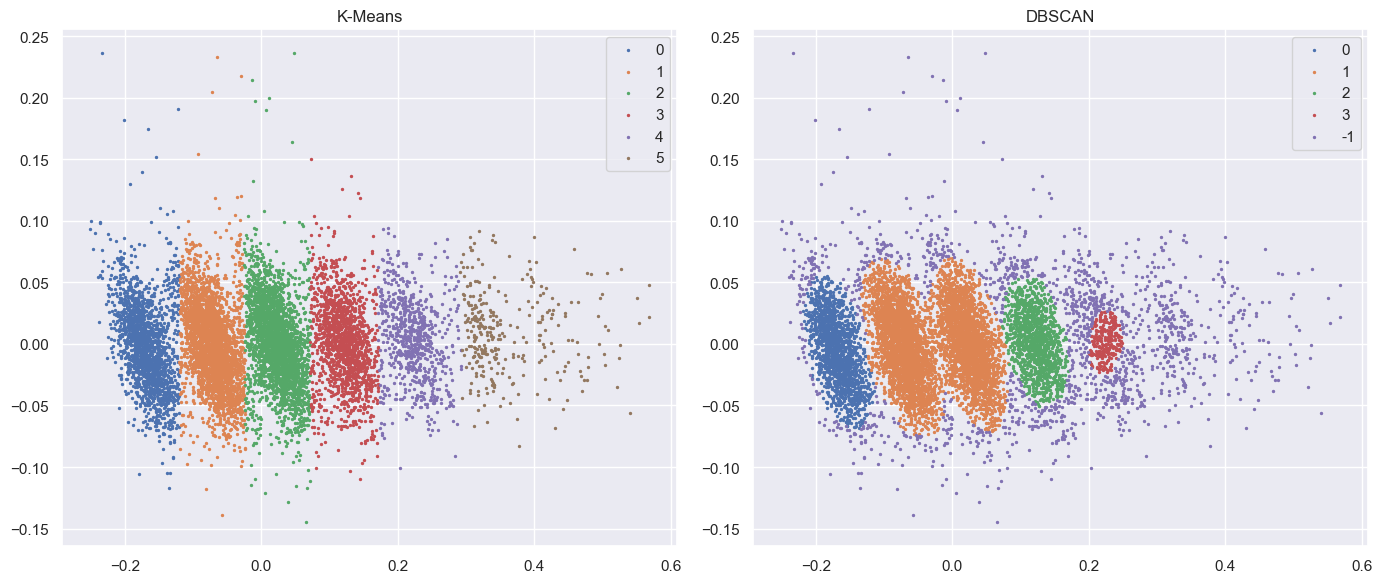

In [52]:
# クラスタリング結果
fig, ax = plt.subplots(1, 2, figsize=(14,6), tight_layout=True)

for photon_count in set(pca_df["kmeans_pred"]):
    ax[0].scatter(pca_df[pca_df["kmeans_pred"]==photon_count]["first_component"], pca_df[pca_df["kmeans_pred"]==photon_count]["second_component"], s=2, label=photon_count)

for photon_count in set(pca_df["dbscan_pred"]):
    ax[1].scatter(pca_df[pca_df["dbscan_pred"]==photon_count]["first_component"], pca_df[pca_df["dbscan_pred"]==photon_count]["second_component"], s=2, label=photon_count)

ax[0].set_title("K-Means")
ax[1].set_title("DBSCAN")
ax[0].legend()
ax[1].legend()
plt.show()

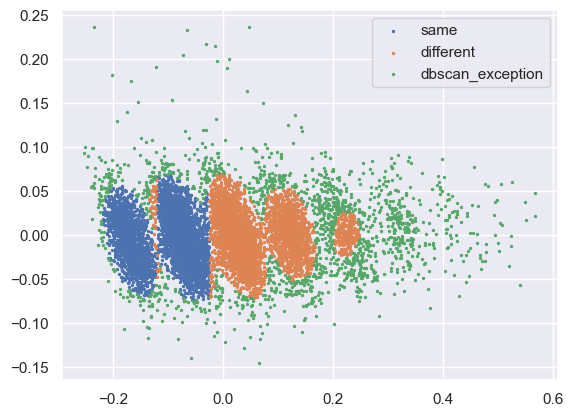

In [53]:
# K-MeansとDBSCANで予測が同じもの、異なるものを確認
same_pred = pca_df[pca_df["kmeans_pred"]==pca_df["dbscan_pred"]]
different_pred = pca_df[(pca_df["dbscan_pred"] != pca_df["kmeans_pred"]) & (pca_df["dbscan_pred"] != -1)]
dbscan_exception = pca_df[pca_df["dbscan_pred"]==-1]
plt.scatter(same_pred["first_component"], same_pred["second_component"], s=2, label="same")
plt.scatter(different_pred["first_component"], different_pred["second_component"], s=2, label="different")
plt.scatter(dbscan_exception["first_component"], dbscan_exception["second_component"], s=2, label="dbscan_exception")
plt.legend()
plt.show()

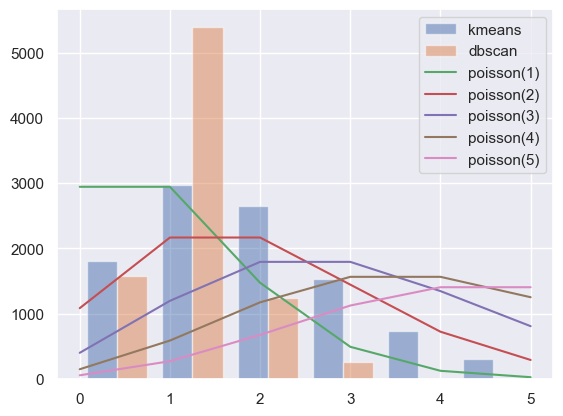

In [54]:
# クラスタのヒストグラムがpoisson分布に従っているか確認
def poisson(x, lam=1):
    return 8000 * (np.e ** (-lam)) * (lam ** x) / math.factorial(x)
x_list = np.arange(0, 6)
lam_list = range(1,6)
y_list_per_lam = {lam: [poisson(x, lam) for x in x_list] for lam in lam_list}

plt.hist([pca_df["kmeans_pred"], pca_df[pca_df["dbscan_pred"]!=-1]["dbscan_pred"]], bins=6, alpha=0.5, label=["kmeans", "dbscan"])
for lam in lam_list:
    plt.plot(x_list, y_list_per_lam[lam], label=f"poisson({lam})")
plt.legend()
plt.show()

# 最適フィルタリング

Shaping ... 
number of selected pulses =  10000


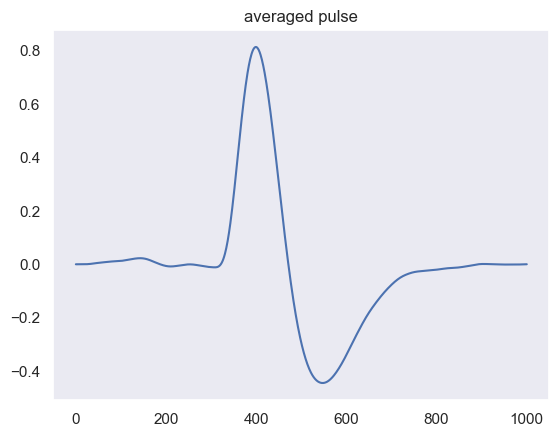

max pulse height =  0.014150716822372296
min pulse height =  8.63413854979736e-06


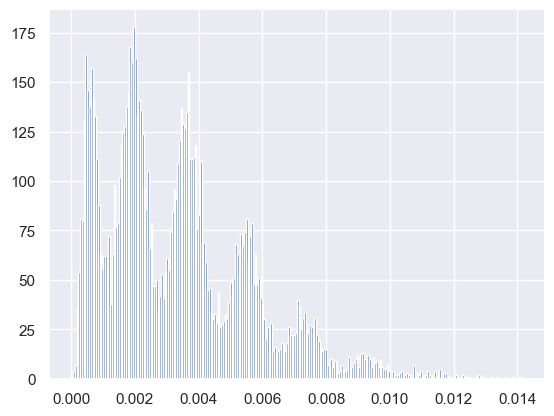

Optimal filtering started ...
|N(f)|^2 =  [0.46481942 0.30328074 0.31248413 ... 0.3262508  0.31248413 0.30328074]
|M(f)|^2 =  [8.82221935e-03 4.91831404e+03 9.47976336e+03 ... 8.81802291e+03
 9.47976336e+03 4.91831404e+03]
max frequency =  1000000.0
max frequency index =  50
0.0 %  ( 0 pulses processed )


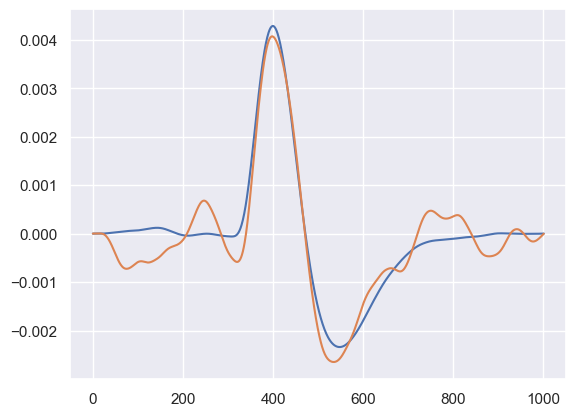

10.0 %  ( 1000 pulses processed )


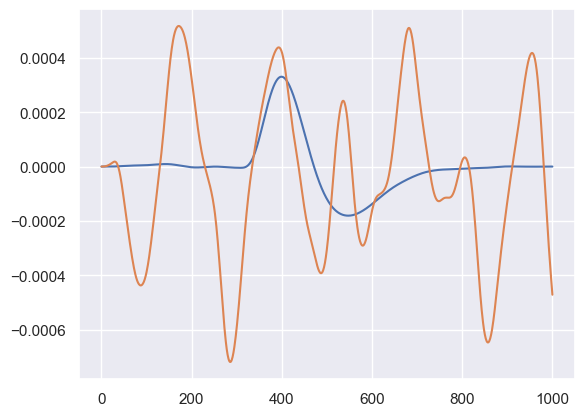

20.0 %  ( 2000 pulses processed )


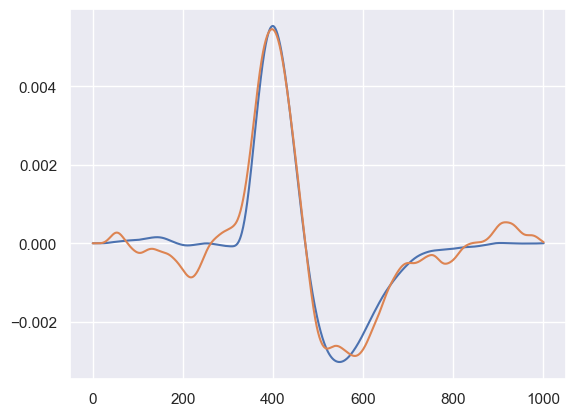

30.0 %  ( 3000 pulses processed )


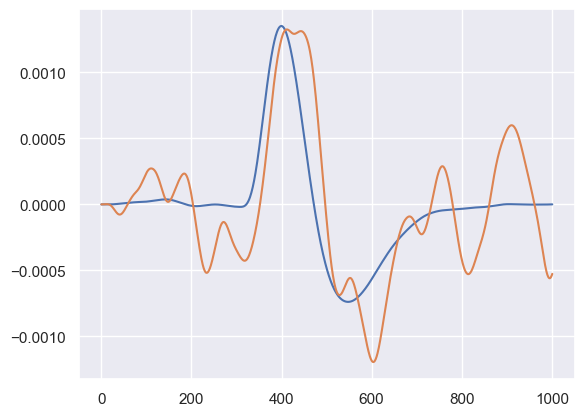

40.0 %  ( 4000 pulses processed )


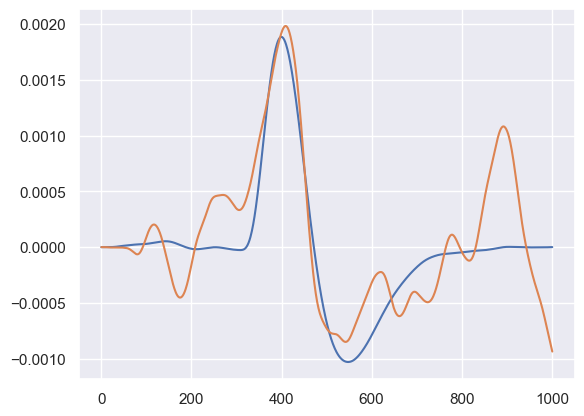

50.0 %  ( 5000 pulses processed )


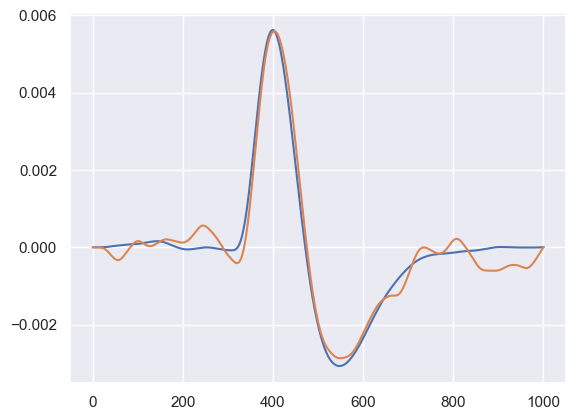

60.0 %  ( 6000 pulses processed )


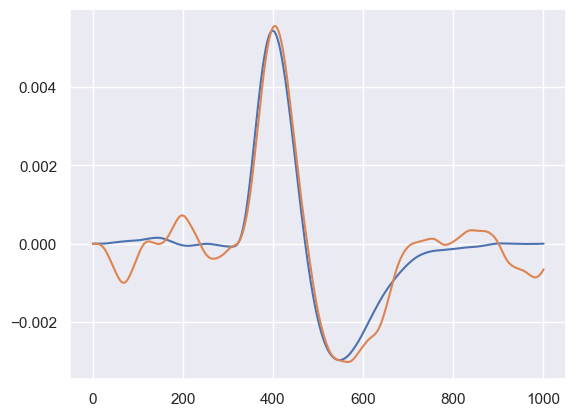

70.0 %  ( 7000 pulses processed )


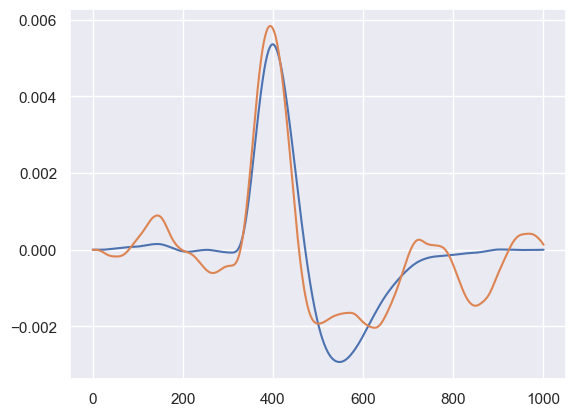

80.0 %  ( 8000 pulses processed )


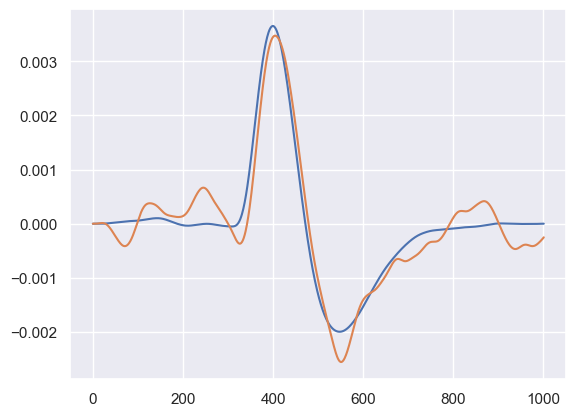

90.0 %  ( 9000 pulses processed )


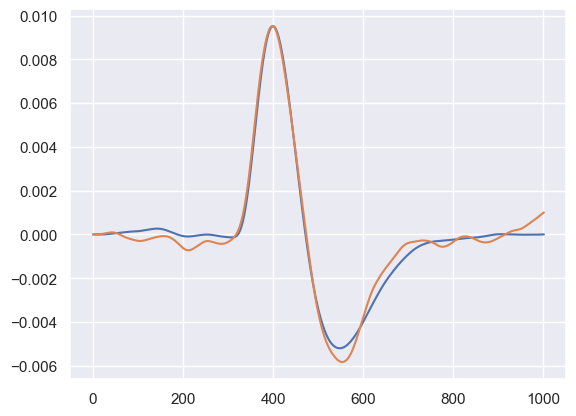

Optimal filtering done.


In [55]:
# 波形整形
pulse = tat.shaping(pulse, dt, 1.0e-6, 1.0e-6, True)

# 平均波形
avg = tat.make_average_pulse(pulse, 0.0, 1.0, 200, 500, True, True, True)

# 単純波高値
tat.simple_ph_spectrum(pulse, 200, 500, True, True)

# 最適フィルタ
ph, hist = tat.optimal_filter_freq(pulse, avg, noise, dt, 1.0e6, False, True)

In [56]:
df_optimal_filtered = pd.DataFrame(pulse)
df_optimal_filtered.index.name = "id"
df_optimal_filtered["ph"] = ph

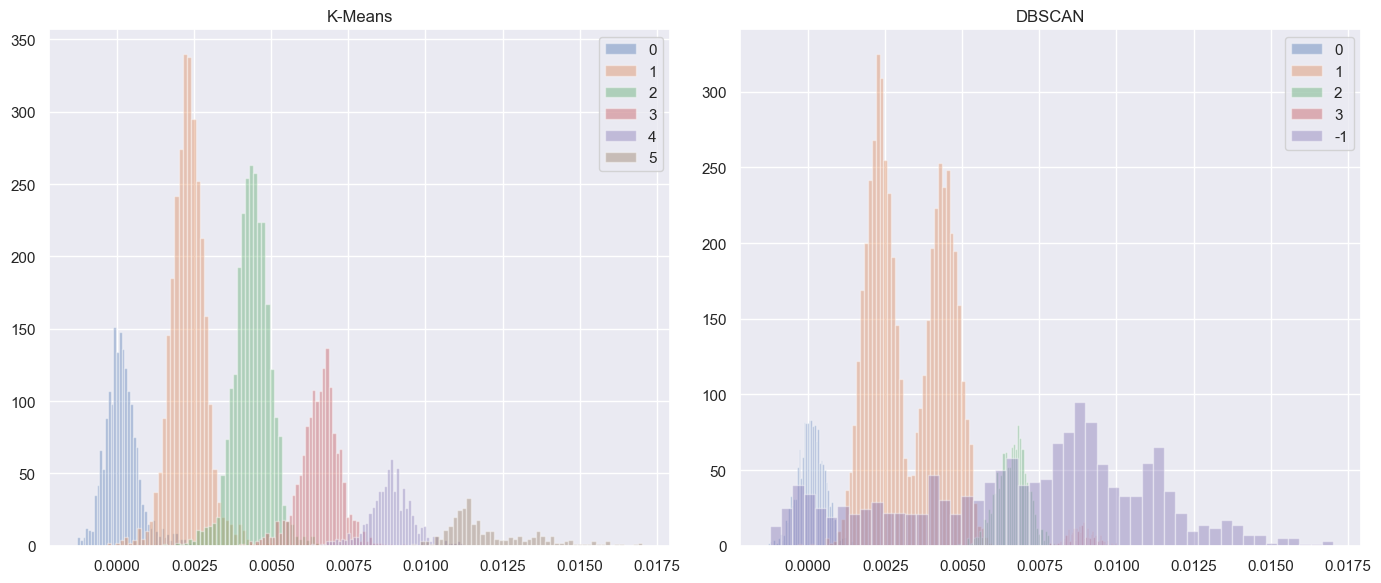

In [57]:
# PCA&クラスタリングの結果と比較 
df_ = pca_df.copy()
df_["ph"] = df_optimal_filtered["ph"]
fig, ax = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
for photon_count in set(df_["kmeans_pred"]):
    ax[0].hist(df_[df_["kmeans_pred"]==photon_count]["ph"], bins=50, label=photon_count, alpha=0.4)
for photon_count in set(df_["dbscan_pred"]):
    ax[1].hist(df_[df_["dbscan_pred"]==photon_count]["ph"], bins=50, label=photon_count, alpha=0.4)

ax[0].set_title("K-Means")
ax[1].set_title("DBSCAN")
ax[0].legend()
ax[1].legend()
plt.show()

# 教師データ作成

In [65]:
# 平均波形を規格化
avg = avg / np.max(avg)

# 最適フィルタの結果から、1光子あたりの波高値を得る
# 今回のデータではおよそ15mV
ph = 0.015 

# 以下の方法で波形データをシミュレーションできる
# (規格化した平均波形)x(1光子あたりの波高値)x(光子数)+ノイズ
train_data = []
photon_num_list_train = []
for _ in range(len(noise)):
    np.random.seed(_)
    num = int(7*np.random.rand())
    simulation_data = avg * ph * num + noise[_, :]
    train_data.append(simulation_data)
    photon_num_list_train.append(num)
train_df = pd.DataFrame(train_data)
train_df["photon_count"] = photon_num_list_train

test_df = df.copy()

In [26]:
# 主成分分析
pca_model_train = PCA(n_components=2)
train_X_pca = pca_model_train.fit_transform(train_df.iloc[:, :-1].values)
# pca_df = pd.DataFrame(data=X_pca, index=df_corrected.index, columns=["first_component", "second_component"])
train_pca_df = pd.DataFrame(data=train_X_pca, columns=["first_component", "second_component"])
train_pca_df["photon_count"] = train_df["photon_count"]

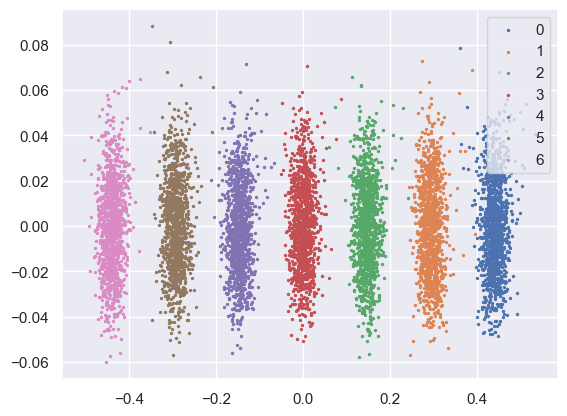

In [27]:
for photon_count in set(train_pca_df["photon_count"]):
    plt.scatter(train_pca_df[train_pca_df["photon_count"]==photon_count]["first_component"], train_pca_df[train_pca_df["photon_count"]==photon_count]["second_component"], s=2, label=photon_count)
plt.legend()
plt.show()

## ロジスティック回帰

In [75]:
from sklearn import model_selection, linear_model, metrics
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.values
print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")

lm = linear_model.LogisticRegression(multi_class="ovr", solver="liblinear")
lm.fit(X_train, y_train)
predictions = lm.predict([X_test[0]])

X_train : (10000, 1002)
X_test : (10000, 1002)
y_train : (10000,)


In [77]:
for _ in range(10):
    prediction = lm.predict([X_test[_]])
    print(prediction)

[1]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[1]


<Axes: >

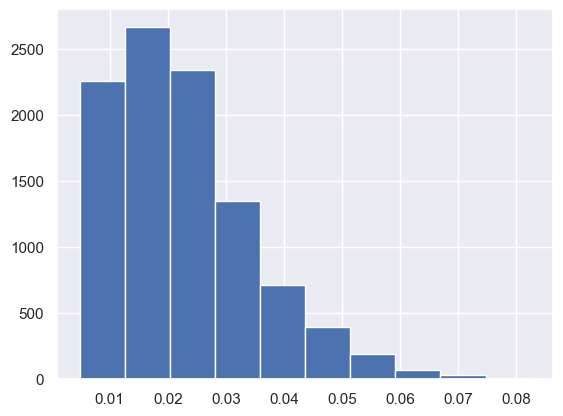

In [74]:
test_df.max(axis=1).hist()

## DNN

In [106]:
def dnn_model():
    model = Sequential()
    model.add(Dense(512, input_dim=1002, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(7, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

train_X = train_df.iloc[:, :-1]
train_y = train_df.iloc[:, -1]

eval_X = eval_df.iloc[:, :-1]
eval_y = eval_df.iloc[:, -1]

model = dnn_model()
model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(eval_X, eval_y))

predictions = model.predict(test_X)
predicted_classes = tf.argmax(predictions, axis=1)
test_df["predicted_label"] = predicted_classes.numpy()

Epoch 1/10
250/250 [==============================] - 2s 5ms/step - loss: 0.4384 - accuracy: 0.8524 - val_loss: 0.0246 - val_accuracy: 0.9980
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0251 - accuracy: 0.9948 - val_loss: 0.3343 - val_accuracy: 0.8660
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1343 - accuracy: 0.9614 - val_loss: 0.0093 - val_accuracy: 0.9975
Epoch 4/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0079 - accuracy: 0.9987 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 5/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0076 - accuracy: 0.9989 - val_loss: 0.0083 - val_accuracy: 0.9990
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0677 - accuracy: 0.9794 - val_loss: 0.0031 - val_accuracy: 0.9995
Epoch 7/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 

Epoch 1/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.0069 - val_accuracy: 0.9980
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 4.9829e-04 - val_accuracy: 1.0000
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0980 - accuracy: 0.9775 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 4/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0082 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 8.3529e-04 - val_accuracy: 1.0000
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 9.1321e-04 - accuracy: 1.0000 - val_loss: 5.9763e-04 - val_accuracy: 1.0000
Epoch 7/10
250/250 [==============================] - 1s 5ms/step - loss: 6.7827e-04 - accuracy: 1.0000 - val_loss: 4.0462e-04 - val

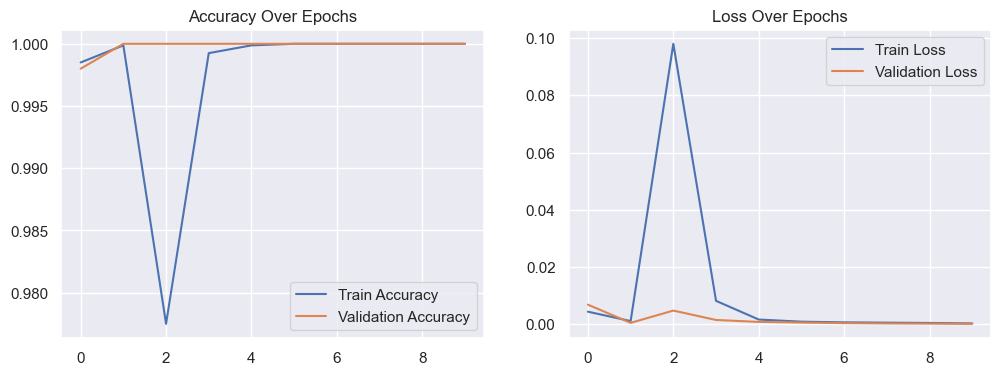

In [107]:
history = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(eval_X, eval_y))

# 精度のプロット
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()